# 😄Sentiment😡 Analysis in Twitter

EDA, preprocessing and test evaluation included.

Models used:
1. Logistic Regression
2. TextBlob
3. Neural Network (Pytorch Lightning)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle

ModuleNotFoundError: No module named 'numpy'

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# load the data
data = pd.read_csv('twitter_training.csv', header=None)
val_data = pd.read_csv('twitter_validation.csv', header=None)

In [4]:
data

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [5]:
val_data

,0,1,2,3
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...
...,...,...,...,...
995,4891,GrandTheftAuto(GTA),Irrelevant,⭐️ Toronto is the arts and culture capital of ...
996,4359,CS-GO,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
997,2652,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,8069,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.


In [6]:
# columns names
data.columns = ['#', 'refers to', 'sentiment', 'text']
val_data.columns = data.columns

In [7]:
# global names
TARGET = 'sentiment'

## EDA

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   #          74682 non-null  int64 
 1   refers to  74682 non-null  object
 2   sentiment  74682 non-null  object
 3   text       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


### Nans

In [10]:
data.isnull().sum()

#              0
refers to      0
sentiment      0
text         686
dtype: int64

In [11]:
val_data.isnull().sum()

#            0
refers to    0
sentiment    0
text         0
dtype: int64

There are 686 samples with no text. As text information is crutial for us, we are going to remove these samples for both EDA anf models fitting.

In [12]:
# drop samples with nans
data.dropna(inplace=True, axis=0)

### Text stats

In [13]:
texts = data['text']

In [14]:
text_lens = [len(t.split()) for t in texts.values]
len_mean = np.mean(text_lens)

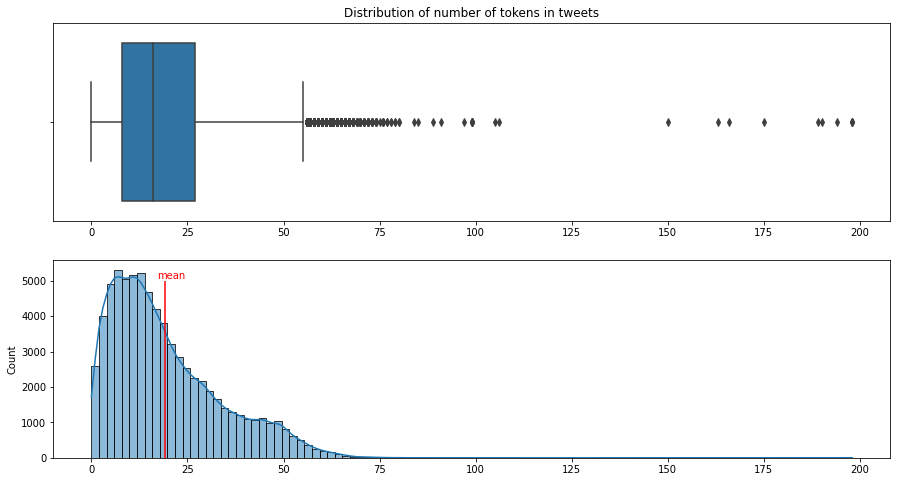

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8))
axes[0].set_title('Distribution of number of tokens in tweets')
sns.boxplot(text_lens, ax=axes[0])
sns.histplot(text_lens, bins=100, kde=True, ax=axes[1])
axes[1].vlines(len_mean, 0, 5000, color = 'r')
plt.annotate("mean", xy=(len_mean, 5000), xytext=(len_mean-2, 5050),
            color='r')
plt.show()

Mean length of tweets is nearly 23 tokens. The distribution is scewed positively and a few outliers are observed on the right tail. Some of them are clode to the right whisker but some are located far from the majority of points. Let investigate them!

In [16]:
extreme_outliers = data['text'][np.array(text_lens) > 125]

In [17]:
for idx in extreme_outliers.index:
    print(idx, 'Target', data[TARGET][idx])
    print(extreme_outliers[idx])
    print('=-=-=-=-=-=-=-=-'*4, '\n')

1826 Target Neutral
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 

8546 Target Positive
I REALLY HAVE THE OVERWATCH RN GAME. SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEE E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 

10454 Target Positive
_ _ _ _ _ _ 

It interesting how tweets like "######..." become Nagative labeled. Some of these tweets do not contain any textual information. Such precendents could be removed. Some have both meaningful part and plenty of punctuation characters. They could be removed on the preprocessing stage.

Lets investigate outliers points which are closer to the majotiry.

In [18]:
outliers = data['text'][np.array(text_lens) > 60]

In [19]:
for idx in outliers.index:
    print(idx, 'Target', data[TARGET][idx])
    print(outliers[idx])
    print('=-=-=-=-=-=-=-=-'*4, '\n')

124 Target Positive
Finally played through borderlands 3. The actual game I play is great. Almost all guns feel fun, and yet I never once felt much like someone I seriously needed to grind. That pretty story on the other side hand.... All I will say Is that I'm very damn much so forward looking forward to the eventual endless cutscene skip : )
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 

268 Target Irrelevant
4 My favorite games of all time. ( thanks @317Slayer and @Drunk_Cookies! ).. 1. Halo Wars 2 / PlayStation 3 can't even pick. 2 2. New Rocket League. 3. Kingdom Hearts 2. 4. Super Mario Bros All Stars ( this was probably the first game I ever even played ).. @Demintele_Sway... @DiscoSpider93 @Void_BWungus @LSTesports If let ’ s really see em!
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- 

334 Target Neutral
Lee Hey borderlands mutuals fam, sorry I've not been interacting as directly and or playing games as fun much as I had really been but 

Some quick notes:
1. Most of the tweets seem to be meaningful
2. I am concerned about the tweets with repeat words. For instance, I've met a few tweets which containe repeated "Italy"

### Target Analysis

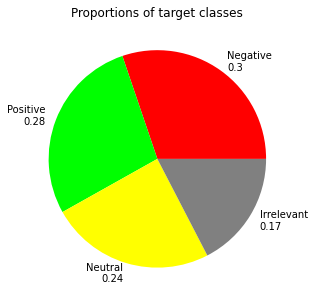

In [20]:
# balance
target_balance = data[TARGET].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(target_balance, labels=[f'{idx}\n{round(target_balance[idx]/len(data), 2)}' for idx in target_balance.index], 
        colors=['r', '#00FF00', '#FFFF00', 'gray'])
plt.title('Proportions of target classes')
plt.show()

Target categories are almost of equal size, so resampling is not required.

In [21]:
# top words
import re
from nltk.corpus import stopwords
stopwords_list = stopwords.words('english')

word_counts = {'Positive': [],
                'Neutral': [],
                'Irrelevant': [],
                'Negative': []}

pattern = re.compile('[^\w ]')
for text, t in zip(data['text'], data[TARGET]):
    text = re.sub(pattern, '', text).lower().split()
    text = [word for word in text if word not in stopwords_list]
    word_counts[t].extend(text)
               

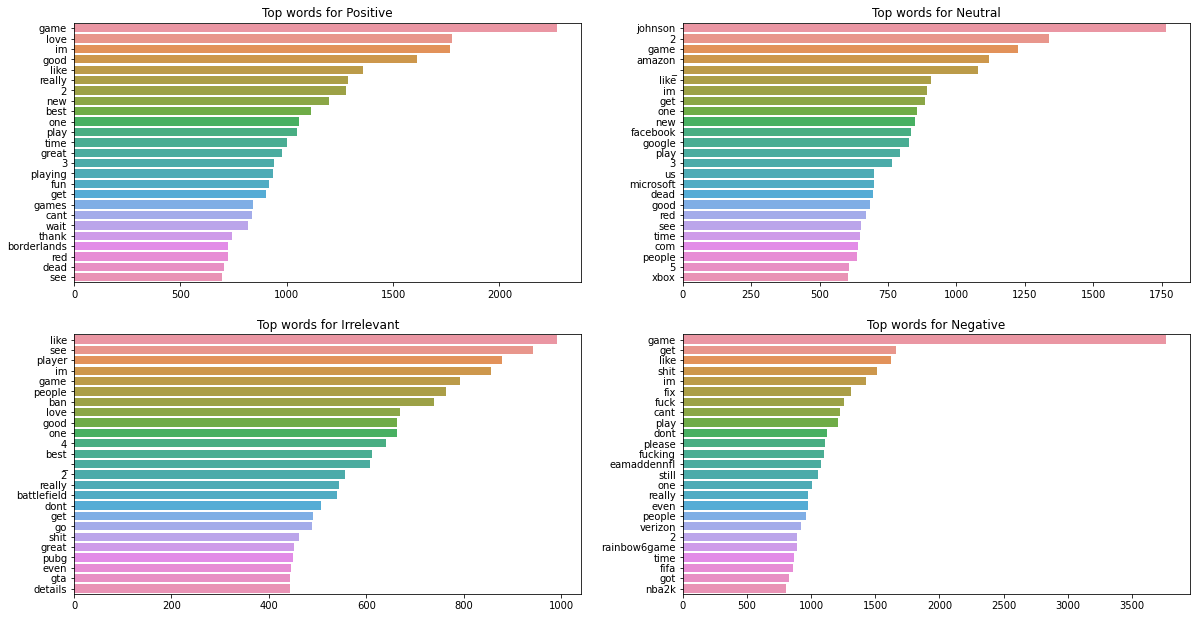

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(20,10.5))
for axis, (target, words) in zip(axes.flatten(), word_counts.items()):
    bar_info = pd.Series(words).value_counts()[:25]
    sns.barplot(x=bar_info.values, y=bar_info.index, ax=axis)
    axis.set_title(f'Top words for {target}')
plt.show()

We can see a clear difference between emotinal and neutral topics. In "Positive" top we can see some positive words, like *love, good, best, great*. In "Negative", instead, we observe lots of swear words. In neutral categories words with positive connotation are also observed, but not so frequent. To sum up, distribution of top-frequent words is different across target categories.

Now, lets see most correlated words for each topic using chi2.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english',
                        max_features=10000)


features = tfidf.fit_transform(data['text']).toarray()

labels = data[TARGET]

print("Each of the %d Text is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

In [ ]:
from sklearn.feature_selection import chi2
N = 10
for label in set(labels):
    features_chi2 = chi2(features, labels == label)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" %(label))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))

In [ ]:
# len for classes without outliers
tweets_len = {'Positive': [],
                'Neutral': [],
                'Irrelevant': [],
                'Negative': []}
pattern = re.compile('[^\w ]')
tweets_len = pd.DataFrame([len(re.sub(pattern, '', text).lower().split()) for text in data['text'] if len(text)< 125],
                         columns=['len'])

In [ ]:
tweets_len['target'] = data[TARGET]

In [ ]:
plt.figure(figsize=(20, 7))
sns.kdeplot(data=tweets_len, x='len', hue='target')
plt.show()

Distributions of tweets length do not differ from each other. We can ensure using ANOVA test as we have equal dispesion and normal-like distribution.

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

#perform two-way ANOVA
model = ols('len ~ target', data=tweets_len).fit()
sm.stats.anova_lm(model, typ=2)

p-value > 0.05, fail to reject H0.

In [ ]:
# emoticons
import emoji
import regex as re

def split_count(text):
    emoji_list = []
    data = re.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
            emoji_list.append(word)
    
    return emoji_list

In [ ]:
target_emojis = {'Positive': [],
                'Neutral': [],
                'Irrelevant': [],
                'Negative': []}

pattern = re.compile('\u200d')
for i, text in enumerate(texts):
    emoji_count = split_count(text)
    if emoji_count:
        emoji_count = [re.sub(pattern, '', e) for e in emoji_count]
        target_emojis[data[TARGET].iloc[i]].extend(emoji_count)

In [ ]:
for t, emojis in target_emojis.items():
    plt.figure(figsize=(10, 5))
    bar_info = pd.Series(emojis).value_counts()[:20]
    print('=========='*10,  f'\nTop emojis for {t} \n', list(bar_info.index))
    bar_info.index = [emoji.demojize(i, delimiters=("", "")) for i in bar_info.index]
    sns.barplot(x=bar_info.values, y=bar_info.index)
        
    plt.title(f'{t}')
    plt.show()

As we can see, the most popular emoji across al the classes is rolling_on_the_floor_laughing except Negative. Here, person_facepalming is on the 1st place. For Positive class, for instance, it is on the 4th. Also, all other emoticons have different distribution across the taget cetegories. Also, It is noticeable that the gap between the most popular (rolling_on_the_floor_laughing) and the second popular emoticons is different and is the smallest for Negative class. 

Negative class also contains some negative emojis like 🤬, 🥴, 🤷 which do not occur in other categories.

In [ ]:
# capitalization distribution
capitalized = [np.sum([t.isupper() for t in text.split()]) for text in np.array(data['text'])]

In [ ]:
capitalized_target = pd.DataFrame([(c, t) for c, t in zip(capitalized, data[TARGET])], columns=['cap', 'target'])

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8))
axes[0].set_title('Distribution of capitalized in tweets')
sns.boxplot(x=capitalized_target['cap'], y=capitalized_target['target'], ax=axes[0])

sns.kdeplot(data=capitalized_target, x='cap', hue='target', ax=axes[1])
plt.show()

In [ ]:
# closer look
capitalized_target_no_outliers = capitalized_target[capitalized_target['cap'] < 75]
fig, axes = plt.subplots(2, 1, figsize=(15, 8))
axes[0].set_title('Distribution of capitalized in tweets')
sns.boxplot(x=capitalized_target_no_outliers['cap'], y=capitalized_target['target'], ax=axes[0])

sns.kdeplot(data=capitalized_target_no_outliers, x='cap', hue='target', ax=axes[1])
plt.show()

In [ ]:
plt.figure(figsize=(5, 8))
sns.heatmap(pd.crosstab(data['refers to'], data[TARGET], normalize='index'), annot=True)
plt.title('Frequencies of meeting referred objects in each category')

## Preprocessing

Sentiment information is mostly expressed on the lexical and punctuational levels. For internet discourse we can also use emoticons as their main purpose is to represent emotions which are our target.

Thus, syntactic relations are not really important to us. As well as semantic features of words. So, we can use simple tf-idf encoders in which we also enclude punctuation (mostly exclamation and question marks), case (CapsLoc as a signal of strong emotions) and emojis.

Required preparation steps:
1. lowercase words, but count for each text how many characters or words we capitalized.
1. remove stopwords and numbers as sentiment neutral
1. decode emojis
1. lemmatize
1. vectorize with tf-idf.
1. Add refers to feature ohe
1. delete nans

Additionally perform feature selection with chi2

In [ ]:
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en import English
import emoji
import spacy
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from sklearn.exceptions import NotFittedError

import re

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")

In [ ]:
ids_to_remove = [1826, 10454, 32186, 68078]
data = data[~data.index.isin(ids_to_remove)]
data.index = range(len(data))

In [ ]:
class Preprocessor:
    def __init__(self, stopwords=stopwords):
        self.vectorizer = TfidfVectorizer(lowercase=False, max_features=8000,
                                         min_df=10, ngram_range=(1, 3),
                                         tokenizer=None)
        self.stopwords = stopwords
        self.vectorizer_fitted = False
        
    def remove_urls(self, texts):
        print('Removing URLs...')
        pattern = re.compile('(\w+\.com ?/ ?.+)|(http\S+)')
        return [re.sub(pattern, '', text) for text in texts]
    
    def remove_double_space(self, texts):
        print('Removing double space...')
        pattern = re.compile(' +')
        return [re.sub(pattern, ' ', text) for text in texts]
        
    def remove_punctuation(self, texts):
        print('Removing Punctuation...')
        pattern = re.compile('[^a-z ]')
        return [re.sub(pattern, ' ', text) for text in texts]
    
    def remove_stopwords(self, texts):
        print('Removing stopwords...')
        return [[w for w in text.split(' ') if w not in self.stopwords] for text in tqdm(texts)]
    
    def remove_numbers(self, texts):
        print('Removing numbers...')
        return [' '.join([w for w in text if not w.isdigit()]) for text in tqdm(texts)]
    
    def decode_emojis(self, texts):
        print('Decoding emojis...')
        return [emoji.demojize(text, language='en') for text in texts] 
    
    def lemmatize(self, texts):
        print('Lemmatizing...')
        lemmatized_texts = []
        for text in tqdm(texts):
            doc = nlp(text)
            lemmatized_texts.append(' '.join([token.lemma_ for token in doc]))
                                    
        return lemmatized_texts
        
    def transform(self, X, y=None, mode='train'):
        X = X.copy()
        print('Removing Nans...')
        X = X[~X.isnull()]                          # delete nans
        X = X[~X.duplicated()]                      # delete duplicates
        
        if mode == 'train':
            self.train_idx = X.index
        else:
            self.test_idx = X.index
        print('Counting capitalized...')
        capitalized = [np.sum([t.isupper() for t in text.split()]) 
                           for text in np.array(X.values)]  # count capitalized
        # X['cap'] = capitalized
        print('Lowering...')
        X = [text.lower() for text in X]             # lower
        X = self.remove_urls(X)                      # remove urls
        X = self.remove_punctuation(X)               # remove punctuation
        X = self.remove_double_space(X)              # remove double space
        X = self.decode_emojis(X)                    # decode emojis
        X = self.remove_stopwords(X)                 # remove stopwords
        X = self.remove_numbers(X)                   # remove numbers                      
        X = self.lemmatize(X)                        # lemmatize
        
        if not self.vectorizer_fitted:
            self.vectorizer_fitted = True
            print('Fitting vectorizer...')
            self.vectorizer.fit(X)

        print('Vectorizing...')
        X = self.vectorizer.transform(X)             # vectorize
        
        return X

In [ ]:
pr = Preprocessor()

In [ ]:
data_train = data
data_test = val_data

y_train = data['sentiment']
y_test = val_data['sentiment']

In [ ]:
data_train_pr = pr.transform(data_train['text'])
data_train_pr = pd.DataFrame.sparse.from_spmatrix(data_train_pr, columns=pr.vectorizer.get_feature_names_out())

ohe = OneHotEncoder()
referring_ohe = ohe.fit_transform(data_train['refers to'][data_train.index.isin(pr.train_idx)].to_numpy().reshape(-1, 1))
referring_ohe = pd.DataFrame.sparse.from_spmatrix(referring_ohe, columns=ohe.get_feature_names_out())

X_train = pd.concat([data_train_pr, referring_ohe], axis=1)
y_train = y_train[y_train.index.isin(pr.train_idx)]
y_train.index = X_train.index

In [ ]:
data_test_pr = pr.transform(data_test['text'], mode='test')
data_test_pr = pd.DataFrame.sparse.from_spmatrix(data_test_pr, columns=pr.vectorizer.get_feature_names_out())

ohe = OneHotEncoder()
referring_ohe = ohe.fit_transform(data_train['refers to'][data_train.index.isin(pr.train_idx)].to_numpy().reshape(-1, 1))
referring_ohe = ohe.transform(data_test['refers to'][data_test.index.isin(pr.test_idx)].to_numpy().reshape(-1, 1))
referring_ohe = pd.DataFrame.sparse.from_spmatrix(referring_ohe, columns=ohe.get_feature_names_out())

X_test = pd.concat([data_test_pr, referring_ohe], axis=1)
y_test = y_test[y_test.index.isin(pr.test_idx)]
y_test.index = X_test.index

In [ ]:
X_test.shape, y_test.shape

In [ ]:
# save prepared data for the future

with open('../X_train.pkl', 'wb') as f:
    pickle.dump(X_train, f)
with open('../X_test.pkl', 'wb') as f:
    pickle.dump(X_test, f)

with open('../y_train.pkl', 'wb') as f:
    pickle.dump(y_train, f)
with open('../y_test.pkl', 'wb') as f:
    pickle.dump(y_test, f)
    
# with open('../X_train.pkl', 'rb') as f:
#     X_train = pickle.load(f)
# with open('../X_test.pkl', 'rb') as f:
#     X_test = pickle.load(f)
# with open('../y_train.pkl', 'rb') as f:
#     y_train = pickle.load(f)
# with open('../y_test.pkl', 'rb') as f:
#     y_test = pickle.load(f)

# Training

In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix

In [ ]:
def train_cv(model, X_train, y_train, params, n_splits=5, scoring='f1_weighted'):
    kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)

    cv = RandomizedSearchCV(model,
                        params,
                        cv=kf,
                        scoring=scoring,
                        return_train_score=True,
                        n_jobs=-1,
                        verbose=2,
                        random_state=1
                        )
    cv.fit(X_train, y_train)

    print('Best params', cv.best_params_)
    return cv

In [ ]:
rs_parameters = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'C': uniform(scale=10),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
    'l1_ratio': uniform(scale=10)
    }

1. Without feature selection
2. MI feature selection

## Training without feature selection

In [ ]:
lr = LogisticRegression()
model_cv_lr = train_cv(lr, X_train, y_train, rs_parameters)

bestimator_lr = model_cv_lr.best_estimator_

Best params {'C': 4.17022004702574, 'l1_ratio': 7.203244934421581, 'penalty': 'l1', 'solver': 'saga'}

In [ ]:
print(classification_report(y_test, bestimator_lr.predict(X_test)))

In [ ]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y_test, bestimator_lr.predict(X_test)), annot=True)
plt.show()

Pretty descend score for a baseline. All classes are predicted almost equally good, confusion matrix look diagonal.

Let's look if we could get the same score after droping some the least important features according to Mutual Information score.

## With MI feature selection

In [ ]:
from sklearn.feature_selection import mutual_info_classif as MIC
mi_score = MIC(X_train,y_train)

In [ ]:
cols_importance = sorted(list(zip(X_train.columns, mi_score)), key=lambda x: x[1], reverse=True)

In [ ]:
plt.figure(figsize=(10, 8))
mi_imp = [pair[1] for pair in cols_importance[:30]]
cols = [pair[0] for pair in cols_importance[:30]]
sns.barplot(x=mi_imp, y=cols)
plt.title('The most important features')
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
mi_imp = [pair[1] for pair in cols_importance[-30:]]
cols = [pair[0] for pair in cols_importance[-30:]]
sns.barplot(x=mi_imp, y=cols)
plt.title('The least important features')
plt.show()

In [ ]:
X_train_6k = X_train[[pair[0] for pair in cols_importance[:6000]]]
X_test_6k = X_test[[pair[0] for pair in cols_importance[:6000]]]

In [ ]:
# save for the future

# with open('../X_train_6k.pkl', 'wb') as f:
#     pickle.dump(X_train_6k, f)
# with open('../X_test_6k.pkl', 'wb') as f:
#     pickle.dump(X_test_6k, f)
    
# with open('../X_train_6k.pkl', 'rb') as f:
#     X_train_6k = pickle.load(f)
# with open('../X_test_6k.pkl', 'rb') as f:
#     X_test_6k = pickle.load(f)

In [ ]:
# leave 6k features
lr = LogisticRegression()
model_cv_lr_6k = train_cv(lr, X_train_6k, y_train, rs_parameters)

bestimator_lr_6k = model_cv_lr_6k.best_estimator_

Best params {'C': 9.13962024579233, 'l1_ratio': 4.572048079869883, 'penalty': 'l1', 'solver': 'saga'}

In [ ]:
print(classification_report(y_test, bestimator_lr_6k.predict(X_test_6k)))

In [ ]:
sns.heatmap(confusion_matrix(y_test, bestimator_lr_6k.predict(X_test_6k)), annot=True)
plt.show()

The scores dropped, but not dramatically. The confusion matrix is still diagonal.

To sum up, with 75% of features we can obtain 97% of baseline accuracy with every feature.

## Binary Classification + Textblob sentiment analysis

Textblob.sentiment is a pretrained instrument which return the polarity and subjectivity of a text.

In the task, we need not only predict sentiment, but also detect irrelevant messages.

In this section, I created a SentimntClassifier which contains a Logistic regression for binary classification: relevant and irrelevant messages. Then relevant texts are passed to textblob.sentiment for polarity estimating.

In [ ]:
from textblob import TextBlob

In [ ]:
class SentimentClassifier:
    def __init__(self):
        self.classifier = LogisticRegression()
    
    def fit_classifier(self, X_vector, y, params):
        model_cv = self.classifier.fit(X_vector, y)
        self.classifier = model_cv#.best_estimator_
        
    def __return_label(self, polarity):
        if -1. <= polarity < 0:
            return 'Negative'
        if polarity == 0:
            return 'Neutral'
        return 'Positive'
        
    def predict_sentiment(self, X_vector, X_texts):
        irrelevance = self.classifier.predict(X_vector)
        X_sentimental = X_texts[irrelevance == 0]
        X_sentimental_idx = X_sentimental.index
        X_irrelevant_index = X_vector[irrelevance == 1].index
        
        pred_sent = [TextBlob(text).sentiment.polarity for text in X_sentimental]
        pred_sent = pd.Series([*map(lambda x: self.__return_label(x), pred_sent )],
                              index=X_sentimental_idx)
        
        pred_irrelevance = irrelevance[irrelevance == 1]
        pred_irrelevance = pd.Series(pred_irrelevance, index=X_irrelevant_index)
        pred_irrelevance = pred_irrelevance.apply(lambda x: 'Irrelevant')
        
        pred = pd.concat([pred_irrelevance, pred_sent], axis=0).sort_index(inplace=False)
        
        return pred

In [ ]:
sent_classifier = SentimentClassifier()

sent_classifier.fit_classifier(X_train_5k, 
                               [1 if target == 'Irrelevant' else 0 for target in y_train], 
                               rs_parameters)

X_texts_test = data['text'][data.index.isin(X_test.index)]

In [ ]:
pred_test = sent_classifier.predict_sentiment(X_test_5k, X_texts_test)
pred_test.value_counts()

In [ ]:
print(classification_report(y_test, pred_test))

In [ ]:
sns.heatmap(confusion_matrix(y_test, pred_test), annot=True)
plt.show()

TextBlob seems to cope poorly with the given task. Meanwhile, not optimized logistic regression managed to classify massages much better than textblob classified later relevant ones.

The confusion matrix is a mess. All classes are mostly detected as the Positive one.

I consider this experiment as a fail and I am not intended to optimize it later.

## Pytorch Lightning classifier

In this section I am bilding a neural network using pytorch lightning.

In [ ]:
import pickle
with open('../X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('../X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('../y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('../y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

In [ ]:
# Lightning Module
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import pytorch_lightning as pl
import torch.utils.data as data_utils
from torch.optim.lr_scheduler import StepLR
from pytorch_lightning.callbacks import LearningRateMonitor
from IPython.display import clear_output
import numpy as np

torch.manual_seed(42)

def plot_loss(losses, title=''):
    """
    plots and saves loss progression while fitting
    """
    if len(losses) < 3:
        return

    pos = np.vstack(losses)
    x, y = pos.T
    plt.clf()
    plt.ion()
    plt.figure(figsize=(9, 5))
    plt.plot(x, y)
    plt.title(title)
    clear_output(wait=True)
    plt.show()

class NNSentimentClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.2)
        self.model = nn.Sequential(
        nn.Linear(8032, 1000),
        nn.ReLU(),
        self.dropout,
        nn.Linear(1000, 100),
        nn.Tanh(),
        self.dropout,
        nn.Linear(100, 1000),
        nn.ReLU(),
        self.dropout,
        nn.Linear(1000, 10),
        nn.ReLU(),
        self.dropout,
        nn.Linear(10, 4)
        )
        self.acc_train_loss = []
        self.acc_val_loss = []
    
    def forward (self, x):
        prediction = self.model(x)
        return prediction
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=0.0001)
        scheduler = StepLR(optimizer, step_size=3, gamma=0.1, verbose=True)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y = y.long()
        prediction = self.forward(x.float())
        loss = F.cross_entropy(prediction, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y = y.long()
        prediction = self.forward(x.float())
        loss = F.cross_entropy(prediction, y)
        self.log('val_loss', loss, prog_bar=True, on_step=False, on_epoch=True)
    
    def test_step(self, test_batch, batc_idx):
        x, y = test_batch
        y = y.long()
        prediction = model.forward(x.float())
        preds = torch.argmax(prediction, dim=1)

        return preds

In [ ]:
# data
target_to_idx = {
    'Irrelevant': 0,
    'Negative': 1,
    'Neutral': 2,
    'Positive': 3
    }

y_train_idx = torch.from_numpy(y_train.map(target_to_idx).values.astype(np.float))
train_data_tensor = data_utils.TensorDataset(torch.from_numpy(X_train.to_numpy().astype(np.float)), y_train_idx)
train_data_tensor, val_data_tensor = random_split(train_data_tensor, [62540, 6948])
train_loader = DataLoader(train_data_tensor, batch_size=32)
val_loader = DataLoader(val_data_tensor, batch_size=1)

In [ ]:
# model
model = NNSentimentClassifier()
# training

trainer = pl.Trainer(gpus=1, precision=16, limit_train_batches=0.5, max_epochs=50)
trainer.fit(model, train_loader, val_loader)

I've stopped training after noticing that validation score stopped dropping, but started increasing

In [ ]:
y_test_idx = torch.from_numpy(y_test.map(target_to_idx).values.astype(np.float))
test_data_tensor = data_utils.TensorDataset(torch.from_numpy(X_test.to_numpy().astype(np.float)), y_test_idx)
test_loader = DataLoader(test_data_tensor, batch_size=1)

In [ ]:
preds = []
for batch in test_loader:
    x, y = batch
    y = y.long()
    prediction = model.forward(x.float().cuda())
    preds.extend(torch.argmax(prediction, dim=1).cpu())

In [ ]:
print(classification_report(preds, y_test_idx))

In [ ]:
sns.heatmap(confusion_matrix(preds, y_test_idx), annot=True)
plt.show()

The netwok allowed to increase test score not significantly: from 91% to 93% accuracy.

The class which is predicted less accurate than the others is the second (Neutral). And this could be understood from the nature of the classes where the "middle position" is not that destinctive as the polar positions.

In [ ]:
# save the net 
torch.save(model.state_dict(), 'net.pt')

## Conclusion
To solve the given task, the raw data was preprocessed the following way:
1. Texts were cleaned from punctuation, urls etc.
2. Texts were lemmatized
3. Texts were vectorized with TF-IDF vectorizer.
4. Categorical features were one-hot-encoded.
* For some models feature selection was applied using Mutual Information score.

In this notebook several experiments were condated implementing the following models:
1. Logistic Regression
2. Logistic Regression + feature selection
3. Binary Logistic Regression + TextBlob
4. Neural Network.

Neural Network showed the best results (93% accuracy), which is not far away from the Logistic Regression baseline (91% accuracy).
Feature selection allowed to decrease number of features from 8032 to 6000 keeping more than 95% performance (88% accuracy compared to 91%).

TextBlob pretrained model was not successfull on this task.

Thanks for your attention!
Upvotes and comments are highly appreciated 🙃